In [1]:
from glob import glob
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import easyocr

from skimage.filters import threshold_local
from PIL import Image
from prettytable import PrettyTable

In [2]:
img_paths = glob("/kaggle/input/food-nutrition-labels/labels/*")

In [3]:
def show_img(path, size = (10, 10)):
    fig, ax = plt.subplots(figsize=size)
    ax.imshow(plt.imread(path))
    ax.axis('off')
    plt.show()

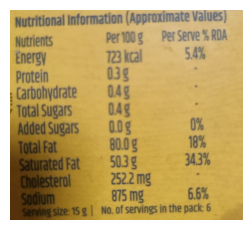

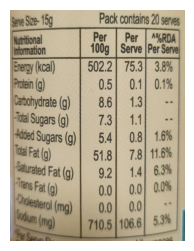

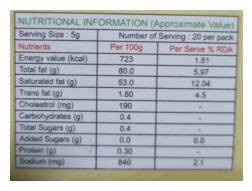

In [4]:
for path in img_paths:
    show_img(path, (3, 3))

In [5]:
#Resize image
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

#Display grey scale image
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

#Display RGB colour image
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

#We will use approxPolyDP for approximating more primitive contour shape consisting of as few points as possible
#Approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)
def get_rectangular_contours(contours):
    """Approximates provided contours and returns only those which have 4 vertices"""
    res = []
    for contour in contours:
        hull = cv2.convexHull(contour)
        peri = cv2.arcLength(hull, closed=True)
        approx = cv2.approxPolyDP(hull, 0.04 * peri, closed=True)
        if len(approx) == 4:
            res.append(approx)
    return res
#Find 4 points of table
def get_table_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is table's rectangle
        if len(approx) == 4:
            return approx
        
#Convert 4 points into lines / rect      
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

#Original table with wrapped perspective
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

#Threshold image
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique

# Plot EasyOCR output
def plot_extractions(img, results):
    fig, ax = plt.subplots()

    ax.imshow(img, cmap='Greys_r')
    for bbox, text, conf in results:
        a, b, c, d = bbox
        rect = patches.Rectangle((a[0], a[1]), c[0]-a[0], c[1]-a[1], linewidth=1, edgecolor='r', facecolor='none', label=text)
        ax.add_patch(rect)
    pos = ax.get_position()
    ax.axis('off')
    ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
    plt.show()
    
# Line by Line Extraction of output
def extract_text_by_line(results, thresh=0.5):
    extracted_text = []

    prev_bbox, prev_text, prev_conf = results[0]
    extracted_text.append(prev_text)
    prev_a, prev_b, prev_c, prev_d = prev_bbox

    prev_y = prev_a[1] # horizontal
    prev_height = abs(prev_a[1]-prev_c[1])
    i=1
    for i in range(1, len(results)):
        bbox, text, conf = results[i]
        a, b, c, d = bbox
        y = a[1]
        if abs(y-prev_y) > thresh * prev_height:
            extracted_text.append("\n")
        extracted_text.append(text)
        prev_bbox, prev_text = bbox, text
        prev_y = y
        prev_height = abs(a[1]-c[1])
    return " ".join(extracted_text)

In [6]:
image = cv2.imread(img_paths[2])

#Downscale image.
#Finding table contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

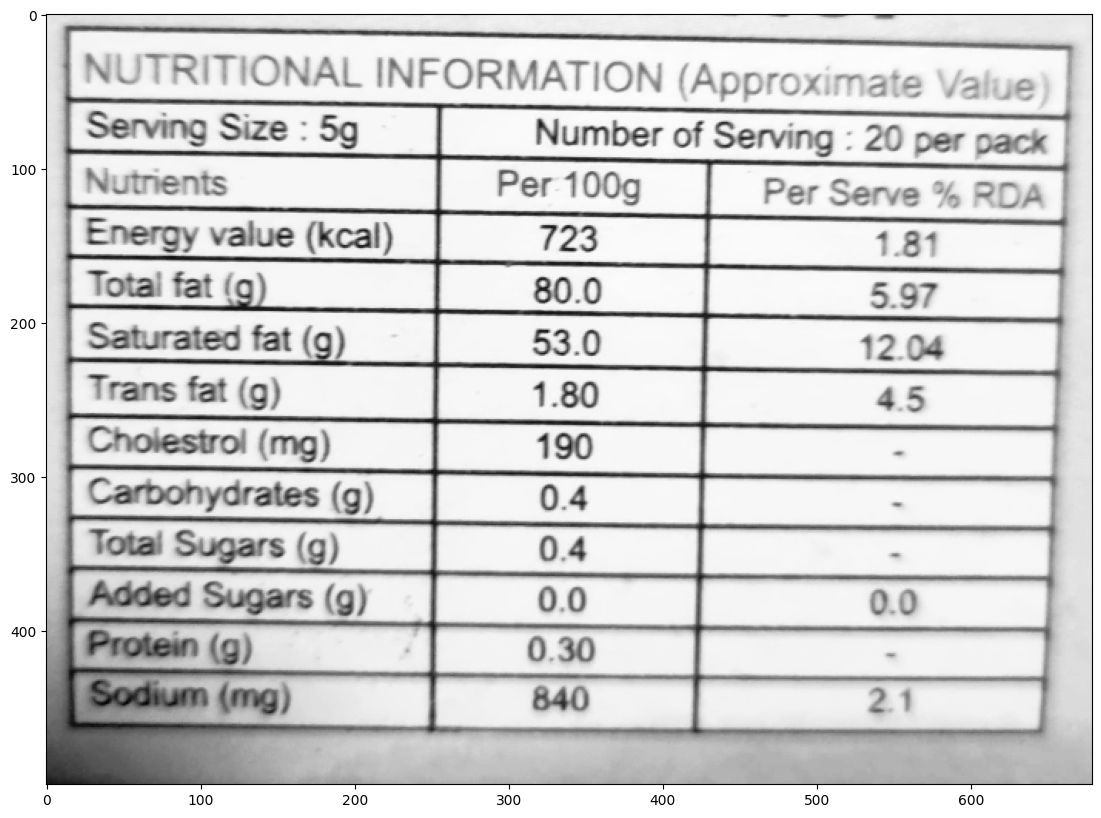

In [7]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

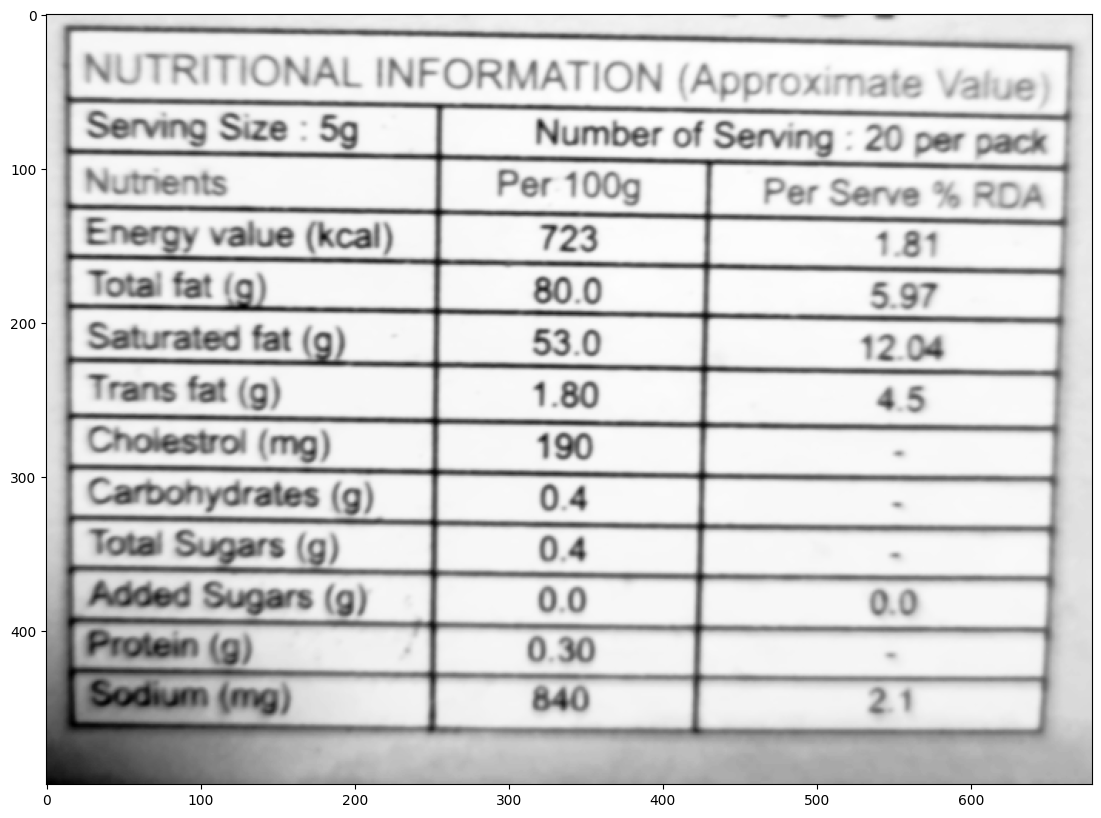

In [8]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)


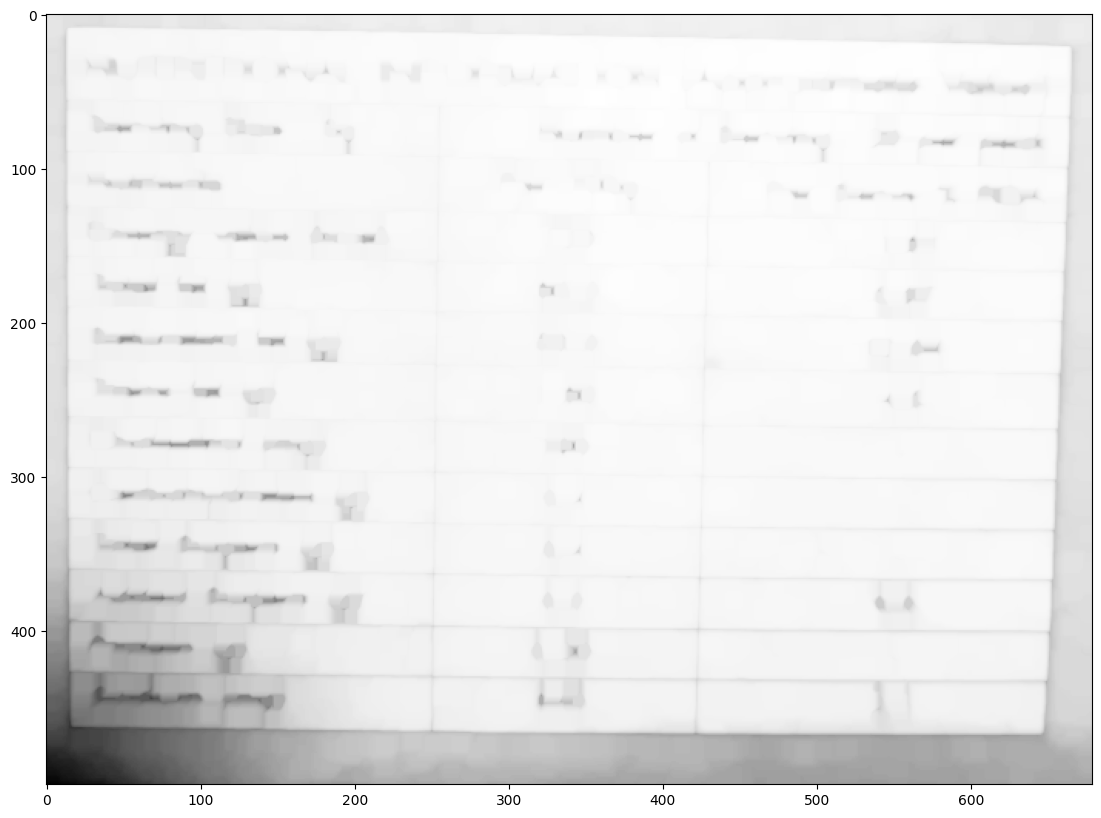

In [9]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

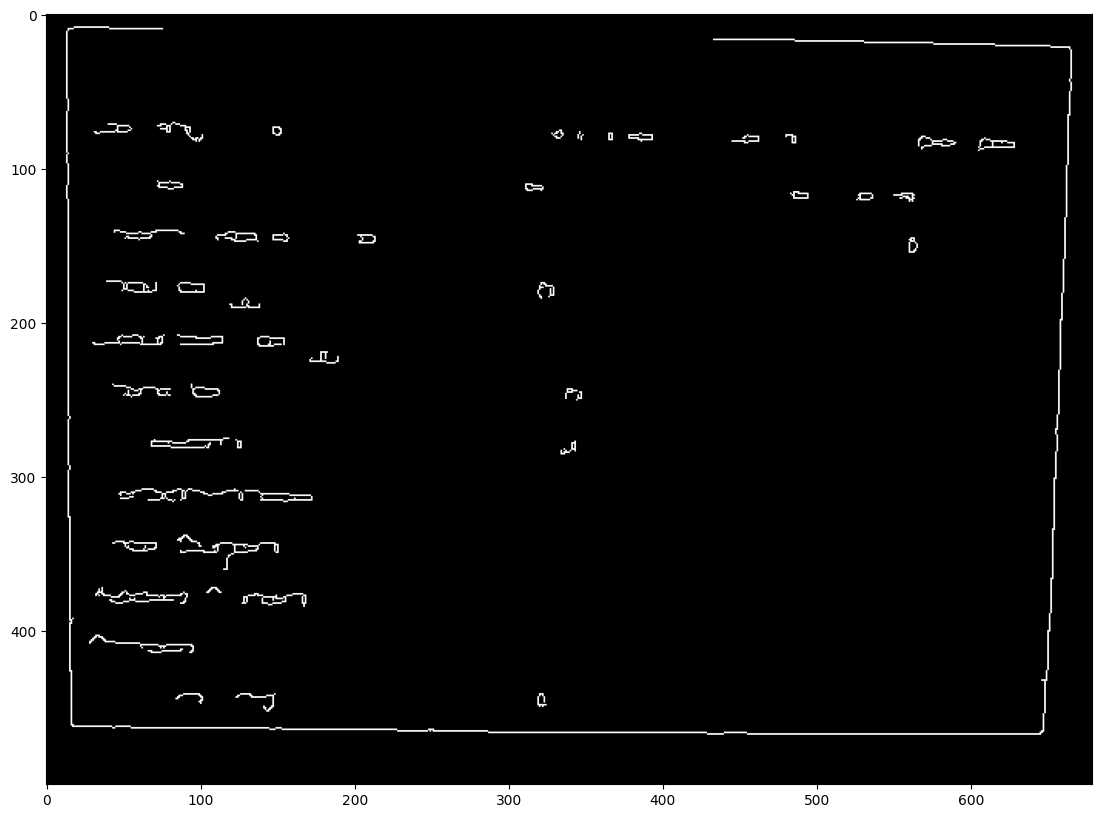

In [10]:
edged = cv2.Canny(dilated, 50, 125, apertureSize=3)
plot_gray(edged)

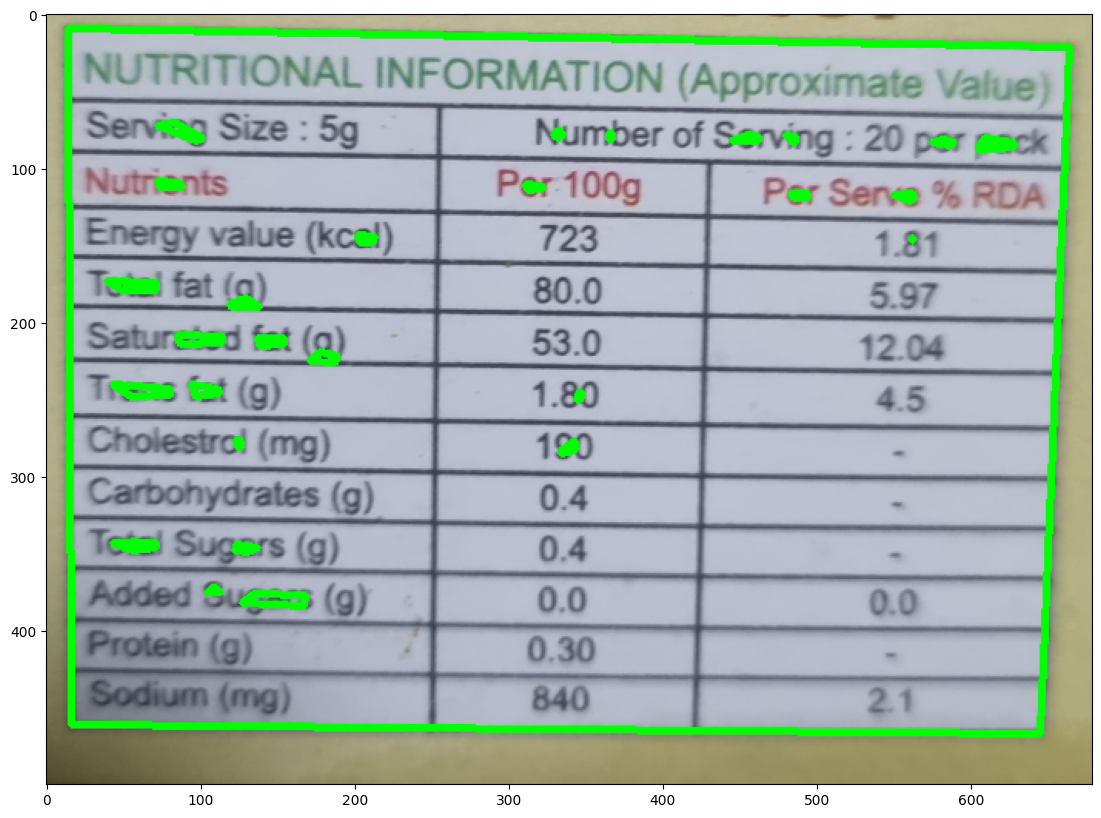

In [11]:
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# quad approximation for all contours
contours = get_rectangular_contours(contours)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

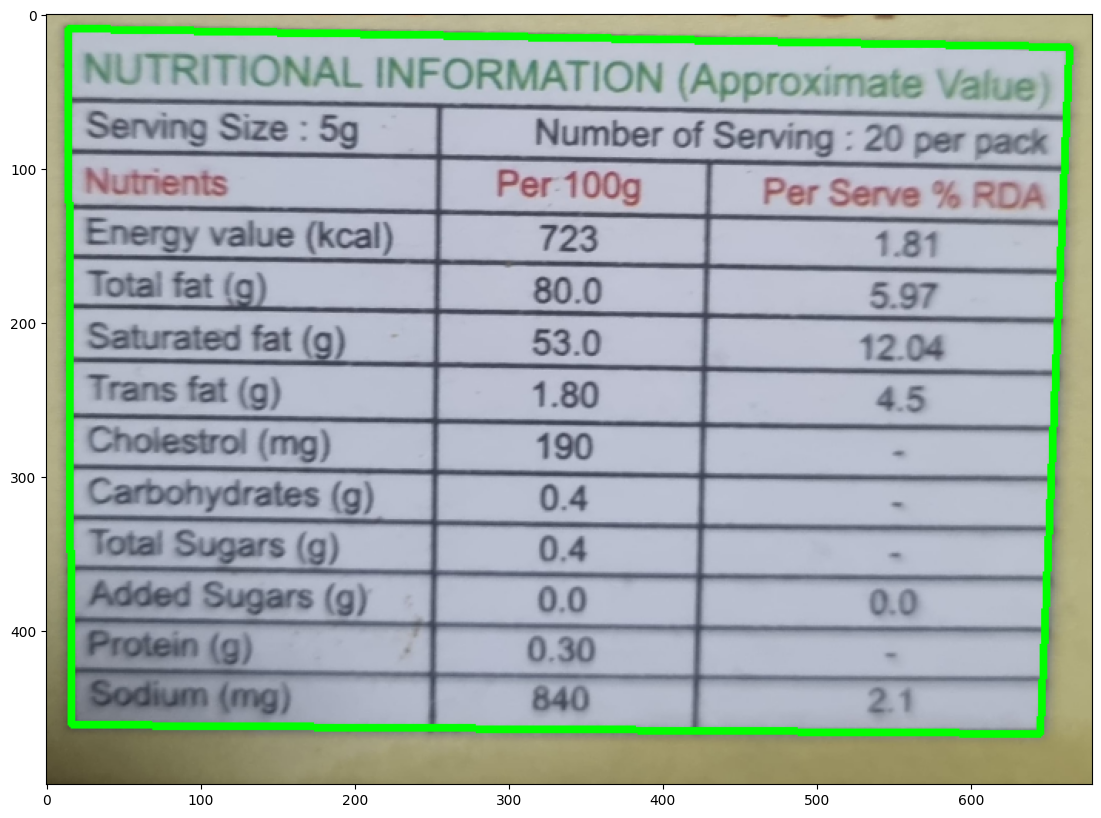

In [12]:
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:1]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [13]:
table_contour = get_table_contour(largest_contours)

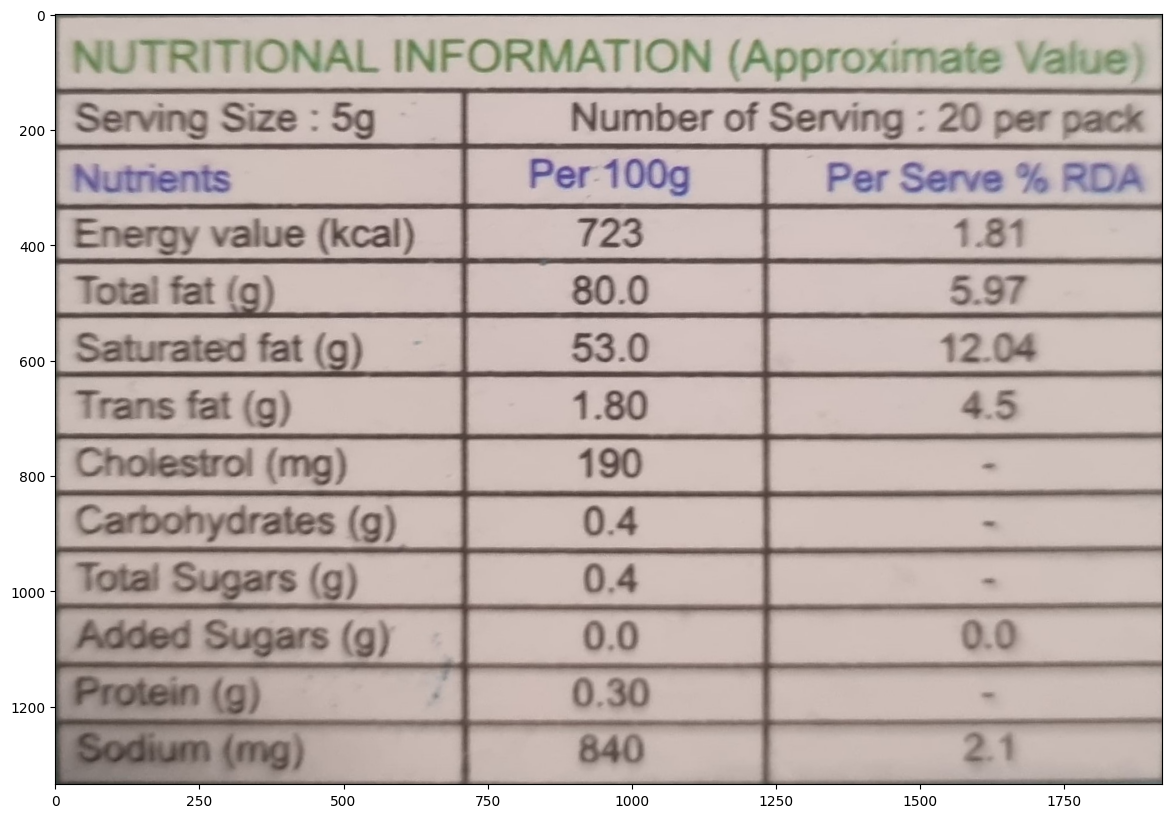

In [14]:
scanned = wrap_perspective(original.copy(), contour_to_rect(table_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

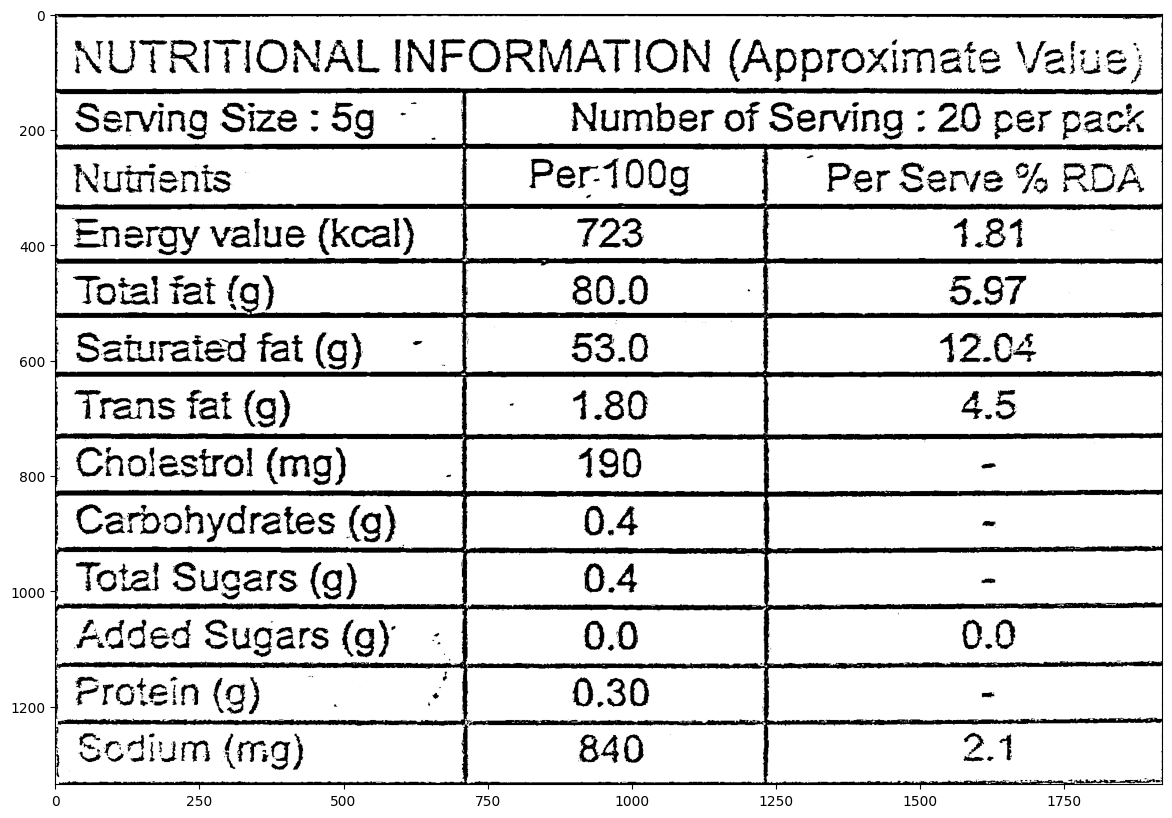

In [15]:
result = bw_scanner(scanned)
plot_gray(result)

In [16]:
reader = easyocr.Reader(['en'], gpu = False)

In [17]:
results = reader.readtext(result)

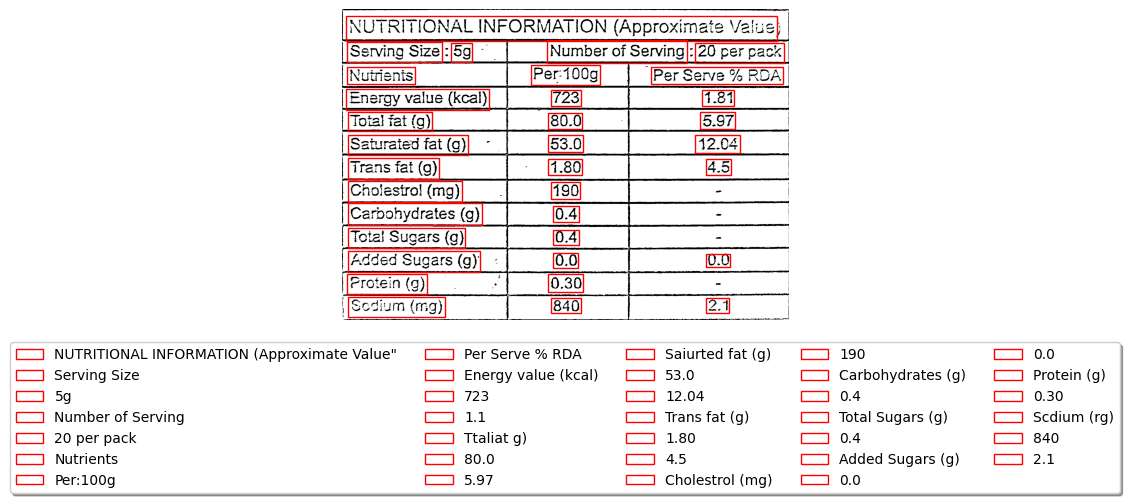

In [18]:
plot_extractions(result, results)

In [19]:
extracted_text = extract_text_by_line(results, 0.3)
print(extracted_text)

NUTRITIONAL INFORMATION (Approximate Value" 
 Serving Size 5g Number of Serving 20 per pack 
 Nutrients Per:100g Per Serve % RDA 
 Energy value (kcal) 723 1.1 
 Ttaliat g) 80.0 5.97 
 Saiurted fat (g) 53.0 12.04 
 Trans fat (g) 1.80 4.5 
 Cholestrol (mg) 190 
 Carbohydrates (g) 0.4 
 Total Sugars (g) 0.4 
 Added Sugars (g) 0.0 0.0 
 Protein (g) 0.30 
 Scdium (rg) 840 2.1


In [20]:
#Extract letters and numbers regex
regex_line = []
for line in extracted_text.splitlines():
    if re.search(r"[a-zA-Z]+\d\.\d+|\d+\s*$", line): # line should start with words, end with digits
        regex_line.append(line)
regex_line

[' Energy value (kcal) 723 1.1 ',
 ' Ttaliat g) 80.0 5.97 ',
 ' Saiurted fat (g) 53.0 12.04 ',
 ' Trans fat (g) 1.80 4.5 ',
 ' Cholestrol (mg) 190 ',
 ' Carbohydrates (g) 0.4 ',
 ' Total Sugars (g) 0.4 ',
 ' Added Sugars (g) 0.0 0.0 ',
 ' Protein (g) 0.30 ',
 ' Scdium (rg) 840 2.1']

In [21]:
nutrient_list = []
for line in regex_line:
    case1 = re.search(r"([^\d]*)\s+(\d+\.\d+|\d+)\s+(\d+\.\d+|\d+)", line)
    case2 = re.search(r"([^\d]*)\s+(\d+\.\d+|\d+)", line)
    if case1:
        nutrient_list.append(list(case1.groups()))
    elif case2:
        nutrient_list.append(list(case2.groups()))
        nutrient_list[-1].append("-")

In [22]:
nutrient_list

[[' Energy value (kcal)', '723', '1.1'],
 [' Ttaliat g)', '80.0', '5.97'],
 [' Saiurted fat (g)', '53.0', '12.04'],
 [' Trans fat (g)', '1.80', '4.5'],
 [' Cholestrol (mg)', '190', '-'],
 [' Carbohydrates (g)', '0.4', '-'],
 [' Total Sugars (g)', '0.4', '-'],
 [' Added Sugars (g)', '0.0', '0.0'],
 [' Protein (g)', '0.30', '-'],
 [' Scdium (rg)', '840', '2.1']]

In [23]:
t = PrettyTable(['Nutrient', 'per 100g', 'per serving'])
for i in range (0,len(nutrient_list)):
    t.add_row([nutrient_list[i][0], nutrient_list[i][1], nutrient_list[i][2]])
print(t)

+----------------------+----------+-------------+
|       Nutrient       | per 100g | per serving |
+----------------------+----------+-------------+
|  Energy value (kcal) |   723    |     1.1     |
|      Ttaliat g)      |   80.0   |     5.97    |
|   Saiurted fat (g)   |   53.0   |    12.04    |
|     Trans fat (g)    |   1.80   |     4.5     |
|    Cholestrol (mg)   |   190    |      -      |
|   Carbohydrates (g)  |   0.4    |      -      |
|   Total Sugars (g)   |   0.4    |      -      |
|   Added Sugars (g)   |   0.0    |     0.0     |
|      Protein (g)     |   0.30   |      -      |
|      Scdium (rg)     |   840    |     2.1     |
+----------------------+----------+-------------+


# Known Limitations:
### - if label is on highly curved surface, OCR fails (image 1 of dataset)
### - if label isnt bounded by a box, OCR fails (image 2 of dataset)